In [331]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import spacy
import string
import random
import pickle as pkl
import time 
from os import listdir 
from collections import Counter
import torch
from torch.utils.data import Dataset
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm_notebook

# Import and Process Data 

In [339]:
# helper methods to load reviews from directories 

def load_single_review(fdir, fname): 
    """ Takes as input file directory and file name of a single review, returns review as string """
    fpath = fdir + '/' + fname 
    with open(fpath, 'r') as f: 
        review = f.read()
        return review 
    
def load_dir_reviews(fdir): 
    """ Takes as input file directory where reviews are stored, returns them as a list of review strings """
    fnames = [f for f in listdir(fdir)]
    reviews = [load_single_review(fdir, fname) for fname in fnames]
    return reviews

def combine_data(neg_reviews, pos_reviews): 
    """ Combines lists of negative and positive reviews, returns a combined dataset comprising reviews and labels """
    neg_with_labels = [(review, 0) for review in neg_reviews] 
    pos_with_labels = [(review, 1) for review in pos_reviews]
    combined = neg_with_labels + pos_with_labels
    combined = random.sample(combined, len(combined))
    reviews = [comb[0] for comb in combined]
    labels = [comb[1] for comb in combined]
    return reviews, labels 

In [340]:
# load reviews into lists 
train_val_neg = load_dir_reviews('aclImdb/train/neg')
train_val_pos = load_dir_reviews('aclImdb/train/pos')
test_neg = load_dir_reviews('aclImdb/test/neg')
test_pos = load_dir_reviews('aclImdb/test/pos')

In [341]:
# randomly split train into train vs. validation sets 
train_split = int(20000 / 2) 
train_neg = train_val_neg[:train_split]
train_pos = train_val_pos[:train_split]
val_neg = train_val_neg[train_split:]
val_pos = train_val_pos[train_split:]

In [342]:
# combine pos and neg reviews to get unified datasets 
train_data, train_labels = combine_data(train_neg, train_pos)
val_data, val_labels = combine_data(val_neg, val_pos)
test_data, test_labels = combine_data(test_neg, test_pos)
print ("Train dataset size is {}".format(len(train_data)))
print ("Validation dataset size is {}".format(len(val_data)))
print ("Test dataset size is {}".format(len(test_data)))

Train dataset size is 20000
Validation dataset size is 5000
Test dataset size is 25000


# Tokenization

In [344]:
# helper functions to tokenize reviews - optimized  

tokenizer = spacy.load('en_core_web_sm')
punctuations = string.punctuation 

def lower_case_remove_punc(parsed):
    """ Takes text as input and outputs a list of tokens in lowercase without punctuation """
    return [token.text.lower() for token in parsed if (token.text not in punctuations)]

def tokenize_dataset(dataset):
    """ Takes as input a dataset comprising a list of reviews, outputs the tokenized dataset along with 
        a list comprising all the tokens from the dataset """
    token_dataset = []
    for sample in tqdm_notebook(tokenizer.pipe(dataset, 
                                               disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
        tokens = lower_case_remove_punc(sample)
        token_dataset.append(tokens)

    return token_dataset

def save_tokens_to_disk(dataset, destination_path): 
    """ Tokenize dataset as save as pickle to destination path """
    start_time = time.time() 
    token_dataset = tokenize_dataset(dataset)
    with open(destination_path, "wb") as f: 
        pkl.dump(token_dataset, f)
    time_elapsed = (time.time() - start_time) / 60.0 
    print("Data tokenized and saved as {} in {:.1f} minutes".format(destination_path, time_elapsed))

In [343]:
# helper functions to tokenize reviews - slow 

# tokenizer = spacy.load('en_core_web_sm')
# punctuations = string.punctuation 

# def tokenize(review): 
#     """ Takes review as input and outputs a list of tokens in lowercase without punctuation """ 
#     tokens = tokenizer(review)
#     return [token.text.lower() for token in tokens if (token.text not in punctuations)]

# def tokenize_dataset(dataset):
#     """ Takes as input a dataset comprising a list of reviews, outputs the tokenized dataset along with 
#         a list comprising all the tokens from the dataset """
#     token_dataset = []
#     for sample in dataset:
#         tokens = tokenize(sample)
#         token_dataset.append(tokens)
#     return token_dataset 

# def save_tokens_to_disk(dataset, destination_path): 
#     """ Tokenize dataset as save as pickle to destination path """
#     start_time = time.time() 
#     token_dataset = tokenize_dataset(dataset)
#     with open(destination_path, "wb") as f: 
#         pkl.dump(token_dataset, f)
#     time_elapsed = (time.time() - start_time) / 60.0 
#     print("Data tokenized and saved as {} in {:.1f} minutes".format(destination_path, time_elapsed))

In [345]:
# def lower_case_remove_punc(parsed):
#     return [token.text.lower() for token in parsed if (token.text not in punctuations)]

# def tokenize_dataset(dataset):
#     token_dataset = []
#     for sample in tqdm_notebook(tokenizer.pipe(dataset, 
#                                                disable=['parser', 'tagger', 'ner'], batch_size=512, n_threads=1)):
#         tokens = lower_case_remove_punc(sample)
#         token_dataset.append(tokens)

#     return token_dataset

# start_time = time.time() 
# token_dataset = tokenize_dataset(val_data)
# time_elapsed = (time.time() - start_time) / 60.0 
# print(time_elapsed)

In [346]:
save_tokens_to_disk(val_data, "data/val_data_tokens.p")
save_tokens_to_disk(train_data, "data/train_data_tokens.p")
save_tokens_to_disk(test_data, "data/test_data_tokens.p")


Data tokenized and saved as data/val_data_tokens.p in 0.2 minutes



Data tokenized and saved as data/train_data_tokens.p in 0.9 minutes



Data tokenized and saved as data/test_data_tokens.p in 0.9 minutes


In [347]:
# load saved tokens 
train_data_tokens = pkl.load(open("data/train_data_tokens.p", "rb"))
val_data_tokens = pkl.load(open("data/val_data_tokens.p", "rb"))
test_data_tokens = pkl.load(open("data/test_data_tokens.p", "rb"))
all_train_tokens = [item for sublist in train_data_tokens for item in sublist] 

# double check 
print ("Train dataset size is {}".format(len(train_data_tokens)))
print ("Val dataset size is {}".format(len(val_data_tokens)))
print ("Test dataset size is {}".format(len(test_data_tokens)))
print ("Total number of tokens in train dataset is {}".format(len(all_train_tokens)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000
Total number of tokens in train dataset is 4808696


In [348]:
token_counter = Counter(all_train_tokens) 
vocab, count = zip(*token_counter.most_common(10))
count

(261965, 130352, 128951, 116768, 107941, 87781, 74745, 74062, 66302, 58666)

In [349]:
# create vocabulary from 10000 most common tokens in the training set 

max_vocab_size = 10000 
PAD_IDX = 0 
UNK_IDX = 1

def build_vocab(all_tokens): 
    """ Takes list of all tokens and returns:
        - id2token: list of tokens, where id2token[i] returns token that corresponds to i-th token 
        - token2id: dictionary where keys represent tokens and corresponding values represent their indices
    """
    token_counter = Counter(all_tokens)
    vocab, count = zip(*token_counter.most_common(max_vocab_size))
    id2token = list(vocab)
    token2id = dict(zip(vocab, range(2, 2+len(vocab))))
    id2token = ['<pad>', '<unk>'] + id2token 
    token2id['<pad>'] = PAD_IDX 
    token2id['<unk>'] = UNK_IDX
    return token2id, id2token 
    
token2id, id2token = build_vocab(all_train_tokens)

In [350]:
# check the dictionary by loading random token from it

random_token_id = random.randint(0, len(id2token)-1)
random_token = id2token[random_token_id]

print ("Token id {} ; token {}".format(random_token_id, id2token[random_token_id]))
print ("Token {}; token id {}".format(random_token, token2id[random_token]))

Token id 7162 ; token weaker
Token weaker; token id 7162


In [351]:
# convert token to id in the dataset 

def token2index_dataset(tokens_data): 
    indices_data = []
    for datum in tokens_data: 
        index_list = [token2id[token] if token in token2id else UNK_IDX for token in datum]
        indices_data.append(index_list)
    return indices_data 

train_data_indices = token2index_dataset(train_data_tokens)
val_data_indices = token2index_dataset(val_data_tokens)
test_data_indices = token2index_dataset(test_data_tokens)

In [352]:
# check size of data 
print ("Train dataset size is {}".format(len(train_data_indices)))
print ("Val dataset size is {}".format(len(val_data_indices)))
print ("Test dataset size is {}".format(len(test_data_indices)))

Train dataset size is 20000
Val dataset size is 5000
Test dataset size is 25000


In [353]:
# check tokenization of dataset 
print(train_data_tokens[0])
print(train_data_indices[0])

['if', 'you', 'were', "n't", 'there', 'then', 'unfortunately', 'this', 'movie', 'will', 'be', 'beyond', 'compassion', 'for', 'you', 'which', 'as', 'i', 'say', 'is', 'a', 'shame', 'because', 'although', 'some', 'of', 'the', 'acting', 'is', 'amateurish', 'it', 'is', 'meant', 'to', 'be', 'for', 'realism', 'let', "'s", 'face', 'it', '--', 'in', 'real', 'life', 'we', 'do', "n't", 'say', 'things', 'in', 'an', 'exacting', 'or', 'perfect', 'way', 'even', 'when', 'we', 'mean', 'to', 'in', 'this', 'sense', 'it', 'works', 'this', 'however', 'does', 'not', 'apply', 'to', 'our', 'known', 'actors', 'in', 'this', 'film', 'notably', 'jodie', 'foster', 'born', 'a', 'natural', 'the', 'fact', 'that', 'the', 'other', '3', 'girls', 'are', 'not', 'accomplished', 'only', 'adds', 'to', 'the', 'story', '--', 'jodie', 'plays', 'the', 'glue', 'that', 'struggles', 'to', 'keep', 'their', 'friendship', 'close', 'even', 'with', 'the', 'obvious', 'feeling', 'of', 'fatality', 'meaning', 'that', 'no', 'matter', 'how', 

# DataLoader

In [354]:
# define custom dataset class and collate function for data loader 

class MovieReviewsDataset(Dataset): 
    """ 
    Class that represents a train/validation/test dataset that's readable for PyTorch
    Note that this class inherits torch.utils.data.Dataset
    """
    
    def __init__(self, data_list, label_list): 
        """ 
        Initialize dataset by passing in a list of movie review tokens and a list of labels 
        """
        self.data_list = data_list 
        self.label_list = label_list 
        assert (len(self.data_list) == len(self.label_list))
        
    def __len__(self): 
        return len(self.data_list)
    
    def __getitem__(self, key): 
        """
        Triggered when dataset[i] is called, outputs a list of tokens, length of list, and label of the data point
        """
        token_idx = self.data_list[key][:MAX_SENTENCE_LENGTH]
        label = self.label_list[key]
        return [token_idx, len(token_idx), label]
    
def collate_func(batch): 
    """ 
    Customized function for DataLoader that dynamically pads the batch so that the data have the same length
    """
    data_list = [] 
    label_list = [] 
    length_list = [] 
    
    for datum in batch:         
        label_list.append(datum[2])
        length_list.append(datum[1])
        # pad data before appending 
        padded_vec = np.pad(array = np.array(datum[0]), 
                            pad_width = ((0, MAX_SENTENCE_LENGTH - datum[1])), 
                            mode = 'constant', 
                            constant_values = 0)
        data_list.append(padded_vec)
        
    return [torch.from_numpy(np.array(data_list)), torch.LongTensor(length_list), torch.LongTensor(label_list)]

In [355]:
# create data loaders for train/val/test datasets 

MAX_SENTENCE_LENGTH = 200 
BATCH_SIZE = 32

train_dataset = MovieReviewsDataset(train_data_indices, train_labels) 
train_loader = torch.utils.data.DataLoader(dataset = train_dataset, batch_size = BATCH_SIZE, 
                                           collate_fn = collate_func, shuffle = True)

val_dataset = MovieReviewsDataset(val_data_indices, val_labels) 
val_loader = torch.utils.data.DataLoader(dataset = val_dataset, batch_size = BATCH_SIZE, 
                                         collate_fn = collate_func, shuffle = True)

test_dataset = MovieReviewsDataset(test_data_indices, test_labels) 
test_loader = torch.utils.data.DataLoader(dataset = test_dataset, batch_size = BATCH_SIZE, 
                                          collate_fn = collate_func, shuffle = True)

In [356]:
# test data loader on training data 
for i, (data, lengths, labels) in enumerate(train_loader):
    print ("Printing a sample datum (of data length {}):".format(lengths[0]))
    print ("Data is: {}".format((data[0])))
    print ("Label is {}".format((labels[0])))
    break 

Printing a sample datum (of data length 200):
Data is: tensor([  10,  200,   11,  683,   48,    5,  305,   32,  683, 3682,   26,   17,
           1,   37, 1620,    4,   55,  525,  264,    5,   28, 1535,  249,  817,
         507,    2,  496,    5,    2,  373,  160,    3,  793,    7,    1,   22,
           2, 3740,   72,   29, 3351,  354,  394,  659,    5,    1,  124,   27,
          80,  220,   30,  399,  232,  633,    4, 7553,  383,   72,   47,   24,
          69,   28,  967,   22,    2, 5700,   12,  937,    2,  215,   90,   72,
         187,  345,  930,  659,    5,    1,   38,  477,   44,  733,    6,   30,
         289, 4000,   22,    1,   20, 2318, 7223, 8884,   32,    5,  102,    2,
         227,    9, 1042,    5,    1,  188,    6,   30, 6264,    6, 6728,   28,
        1134,    1,   45,    2,  825,   16,   49,    1,   22,    2, 5700,    7,
           4, 2576, 7454,  143,    2,  227,  477,    7,    1,   22,    1,    9,
          22,    4,  166, 4719,    9,    2,    1,   77,  167,    

# Bag-Of-Words Model

In [357]:
# Define model architecture and helper methods 

class BagOfWords(nn.Module): 
    """ 
    BagOfWords classification model 
    """
    
    def __init__(self, vocab_size, emb_dim): 
        """ 
        @param vocab_size: size of the vocabulary 
        @param emd_dim: size of the word embedding 
        """
        super().__init__() 
        self.embed = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        self.linear = nn.Linear(emb_dim, 2)
        
    def forward(self, data, length): 
        """ 
        @param data: matrix of size (batch_size, max_sentence_length). Each row in data represents a review
            that is represented using n-gram index. Note that they are padded to have the same length. 
        @param length: an int tensor of size (batch_size), which represents the non-trivial (i.e. non-padded)
            length of each sentence in the data 
        """
        out = self.embed(data)
        out = torch.sum(out, dim=1)
        out /= length.view(length.size()[0],1).expand_as(out).float()
        
        # return logits
        out = self.linear(out.float())

        return out
    
def test_model(loader, model): 
    """ 
    Helper function that tests the model's performance on a given dataset 
    @param: loader = data loader for the dataset to test against 
    """
    correct = 0 
    total = 0 
    model.eval() 
    
    for data_batch, length_batch, label_batch in loader: 
        outputs = F.softmax(model(data_batch, length_batch), dim=1)
        predictions = outputs.max(1, keepdim=True)[1]    
        total += label_batch.size(0)
        correct += predictions.eq(label_batch.view_as(predictions)).sum().item()
        
    return (100 * correct / total)

In [358]:
# Loss function and hyperparameters 
emb_dim = 100
model = BagOfWords(len(id2token), emb_dim)
learning_rate = 0.01 
num_epochs = 2
criterion = torch.nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [359]:
# Train and Evaluate on Validation Set 

total_steps = 0 
results = []

for epoch in range(num_epochs):
    for i, (data_batch, length_batch, label_batch) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        outputs = model(data_batch, length_batch)
        loss = criterion(outputs, label_batch)
        loss.backward()
        optimizer.step()
        # validate every 100 iterations
        if i > 0 and (i+1) % 100 == 0:
            total_steps = epoch * 625 + (i+1) 
            train_acc = test_model(train_loader, model) # report train accuracy 
            val_acc = test_model(val_loader, model) # report validation accuracy 
            result = {} 
            result['step'] = total_steps 
            result['train_acc'] = train_acc
            result['val_acc'] = val_acc        
            results.append(result)
            print('Epoch: [{}/{}], Step: [{}/{}], Total Steps: {}, Validation Acc: {}, Train Acc: {}'.format( 
                       epoch+1, num_epochs, i+1, len(train_loader), total_steps, val_acc, train_acc))

Epoch: [1/2], Step: [100/625], Total Steps: 100, Validation Acc: 80.04, Train Acc: 82.255
Epoch: [1/2], Step: [200/625], Total Steps: 200, Validation Acc: 83.3, Train Acc: 87.06
Epoch: [1/2], Step: [300/625], Total Steps: 300, Validation Acc: 83.86, Train Acc: 88.745
Epoch: [1/2], Step: [400/625], Total Steps: 400, Validation Acc: 84.1, Train Acc: 90.835
Epoch: [1/2], Step: [500/625], Total Steps: 500, Validation Acc: 84.34, Train Acc: 91.795
Epoch: [1/2], Step: [600/625], Total Steps: 600, Validation Acc: 84.4, Train Acc: 92.375
Epoch: [2/2], Step: [100/625], Total Steps: 725, Validation Acc: 83.64, Train Acc: 93.295
Epoch: [2/2], Step: [200/625], Total Steps: 825, Validation Acc: 83.2, Train Acc: 93.47
Epoch: [2/2], Step: [300/625], Total Steps: 925, Validation Acc: 83.12, Train Acc: 94.005
Epoch: [2/2], Step: [400/625], Total Steps: 1025, Validation Acc: 83.28, Train Acc: 94.485
Epoch: [2/2], Step: [500/625], Total Steps: 1125, Validation Acc: 83.76, Train Acc: 94.99
Epoch: [2/2], S

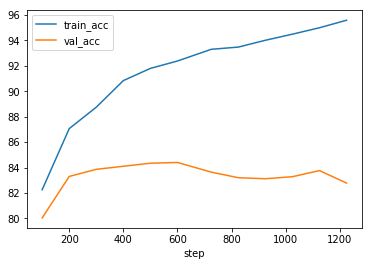

In [360]:
# learning curve 
results_df = pd.DataFrame.from_dict(results)
results_df = results_df.set_index('step')
results_df.plot()

# Varying Preprocessing and Hyperparameters